# Kinetics I

Here, we will get into kinetic analysis.  This lecture covers differential analysis of data collected in a constant volume batch reactor.

## For Fall 2025

Don't get into the extra statistics parts of linear regression until L30 where it starts being useful b/c the data gets noisy. Introduce the regression techniques first, then add the stats later inline in L30, as they are now in L30.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01

Analysis of Data Collected in a Constant Volume Batch Reactor.

The following reaction is carried out in a well-mixed, constant volume batch reactor. The concentration of species A in the tank is initially 10M, and the fluid inside of the reactor has constant density. 
			
$$A \longrightarrow B$$
			
You measure the concentration of species A in this reactor, monitoring how it changes with time.  The data you collect are given in the table below. 

| **time (s)** | **C$_A$ (mol/L)** |  **time (s)**  | **C$_A$ (mol/L)**      |
|:------------:|:-----------------:|:--------------:|:----------------------:|
|0             | 10.0              | 34             | 4.96                   |
|1             | 9.58              | 55             | 4.10                   |
|2             | 9.21              | 89             | 3.33                   |
|3             | 8.87              | 144            | 2.68                   |
|5             | 8.30              | 233            | 2.13                   | 
|8             | 7.62              | 377            | 1.69                   |
|13            | 6.79              | 610            | 1.34                   |
|21            | 5.88              | 987            | 1.06                   |



Assuming the rate law is described by power law kinetics,

$$r = kC_A^{\alpha}$$ 

where $\alpha$ is an integer, determine the reaction order in A and the rate constant for this reaction.

In the cell below, we compile this set of measurements.  In this type of system, it is common to start the system with a known quantity of total moles and a known concentration of reacting species.  Then we allow time to proceed, and we measure the concentrations of reactants and products as a function of time.


We know the following:

\begin{align}
    C_{A0} &= 10 \ \textrm{mol} \ \textrm{L}^{-1} \\
    C_{B0} &= 0 \ \textrm{mol} \ \textrm{L}^{-1} \\
    T &= \textrm{constant}
\end{align}

Usually, when we have batch data, we're looking at something like this...where we've monitored the concentration of A in the reactor as time progresses:

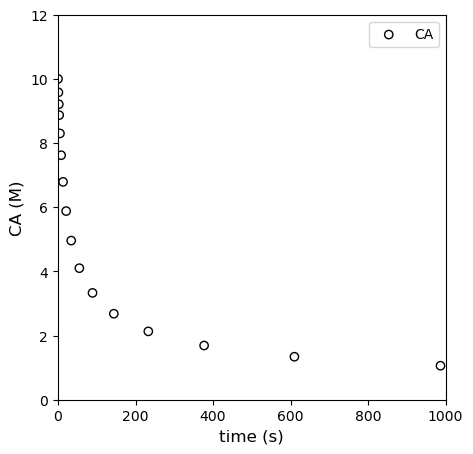

In [2]:
t  = np.array([0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987])#, 1597, 4181, 6765, 10946]) #time in seconds
# CA = np.array([10.0000, 9.5783, 9.2057, 8.8736, 8.3045, 7.6249, 6.7884, 5.8824, 4.9629, 4.0996, 3.3315, 2.6764, 2.1335, 1.692, 1.3375, 1.0551])#, 0.8312, 0.5148, 0.4049, 0.3184])
CA = np.array([10.00, 9.58, 9.21, 8.87, 8.30, 7.62, 6.79, 5.88, 4.96, 4.10, 3.33, 2.68, 2.13, 1.69, 1.34, 1.06])#, 0.8312, 0.5148, 0.4049, 0.3184])
#Concentrations in moles per liter

plt.figure(figsize = (5, 5))
plt.scatter(t, CA, edgecolor = 'black', color = 'none', label = 'CA')
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 1000)
plt.ylim(0, 12)
plt.legend()
plt.show()

Determine the rate law and kinetic parameters $(k, \alpha)$ for this reaction.

### Solution to Example Problem 01

This is our introduction to an "inverse problem," which involves determining a model and the parameters for that model based on our observations of data. To this point, we've only used models (material balances, rate laws, etc.) in order to predict data (e.g., reactor volume required for a certain conversion).  Here, we have to work backwards and use the data to develop the correct model. Extracting information from data can be challenging, but we'll work through a couple of methods and highlight some of the pifalls associated with each one to build experience.

In this case, there is no reason to believe that this reaction is an elementary step, so, at best, we can propose that the rate of reaction depends on temperature (which we capture with a rate constant) and the concentration of the reactant, A, with some unknown order, i.e., we'll propose a power law model:

$$r = k{C_A}^\alpha$$

Now we have to make some decisions about how we'll estimate those parameters $(k, \alpha)$.  It all starts with the material balance on a constant volume batch reactor.  We'll write one on species A:

$$\frac{dN_A}{dt} = R_AV$$

For a constant volume reactor, we can divide through by V and move it inside of the derivative:

$$\frac{dC_A}{dt} = R_A$$

And for a single reaction, we know that $R_A = -r$, so:

$$\frac{dC_A}{dt} = -r$$

We've proposed power law kinetics here, hence:

$$\frac{dC_A}{dt} = -k{C_A}^\alpha$$

Now we have options.  We can generally choose one of two strategies to approach the problem.  The first is called a ***differential*** method of analysis, wherein we attempt to approximate reaction rates by taking numerical derivatives of data.  The second is an ***integral*** method of analysis, where we attempt to solve the material balance and then regress parameters in the resultant model that best describe our data. Ideally, you'll want to use both of them as each has advantages and disadvantages for the analysis of batch reactor data.

Generally, an ***integral method of analysis*** is easiest if we are able to assume a reaction order (1, 2, 3...).  Once we do that, we know we can solve the differential equation symbolically in terms of $k$ and $C_{A0}$. The hard part about this is there is no guarantee that our reaction will be integer or even positive order with respect to a particular variable, so it can be a bit tedious to consider many different reaction orders.

A ***differential method of analysis*** is fast to apply, and it lets us estimate reaction orders and rate constants without solving a differential equation, but taking numerical derivatives is very imprecise and this method is prone to a lot of error, which can make it very difficult to apply to real world data.

In reality, both methods have strengths and weaknesses, and I always use both of them to give me a complete picture of the system under consideration.  Usually, a combination of differential and integral methods will allow us to get a pretty good idea of the reaction order and any kinetic parameters we need.

### A Differential Analysis of Batch Reactor Data

#### Finite Differences

We'll start with a differential method of analysis.  This is based on approximating derivatives with a finite difference method.  This is really straightforward despite the fancy name.  We simply say that we can approximate derivatives from data using the discrete changes in that data that we observe:

$$\frac{dC_A}{dt} \approx \frac{\Delta C_A}{\Delta t}$$

And that is convenient because, ***in a constant volume batch reactor***, we know the relationship between the concentration derivative and the reaction rate, namely:

$$\frac{dC_A}{dt} = -r$$

So, by approximating the time derivative of concentration in a constant volume batch reactor, we are actually getting a reasonable approximation of the reaction rate at a certain condition.

$$\frac{\Delta C_A}{\Delta t} \approx -r$$

Let's start there, if we can take those finite differences, we'll get an estimate of reaction rates.  I am specifically going to use a forward difference method here.  What this approximation says is that:

$$\frac{dC_A}{dt}\bigg|_{C_{A_n}} \approx \frac{C_{A_{n+1}} - C_{A_{n}}}{t_{n+1} - t_n}$$

I can quickly find differences between elements in an array using `numpy.diff()`

In [3]:
ΔCA = np.diff(CA)
print(ΔCA, '\n')
Δt  = np.diff(t)
print(Δt, '\n')
r = -1*ΔCA/Δt
print(r)

[-0.42 -0.37 -0.34 -0.57 -0.68 -0.83 -0.91 -0.92 -0.86 -0.77 -0.65 -0.55
 -0.44 -0.35 -0.28] 

[  1   1   1   2   3   5   8  13  21  34  55  89 144 233 377] 

[0.42       0.37       0.34       0.285      0.22666667 0.166
 0.11375    0.07076923 0.04095238 0.02264706 0.01181818 0.00617978
 0.00305556 0.00150215 0.00074271]


So that is a pretty quick way to convert a concentration vs. time profile into approximate (sometimes very approximate) reaction rates.  As indicated by our definition of the forward difference, these entries represent the derivative at point "$n$".  So the first rate is the rate at `CA[0]`, the second rate is the rate at `CA[1]`, etc.  The only catch is that I have 20 measurements. I can only get 19 derivatives out of 20 measurements based on the forward difference formula.  So the final value in our rate array represents an estimate of the reaction rate at `CA[18]`, i.e., the 19th concentration measurement.  In this case, we don't have an estimate for the rate at `CA[19]` because we are using a forward difference algorithm at it would require us to know the 21st concentration, which we didn't measure.

In [4]:
print(len(CA), '\n')
print(len(r))

16 

15


#### Visualizing rate as a function of CA

Remember: we have a model for how rate should vary with concentration:

$$r = k{C_A}^\alpha$$

Let's plot rate against $C_A$ and see what it looks like:

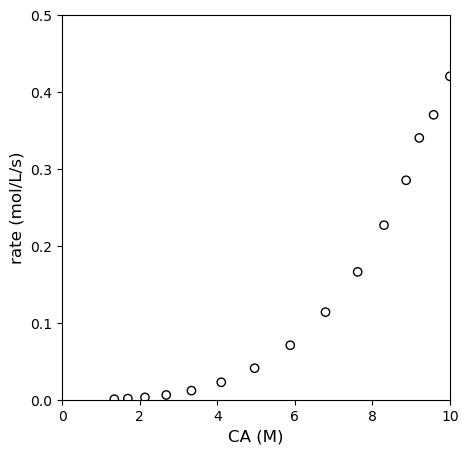

In [5]:
Cmod = CA[:-1] #keep all but last CA entry

plt.figure(figsize = (5, 5))
plt.scatter(Cmod, r, edgecolor = 'black', color = 'none')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (mol/L/s)', fontsize = 12)
plt.xlim(0, 10)
plt.ylim(0, 0.5)
plt.show()

#### Attempting Linearization of rate vs. CA data

Well, OK...rate increases with concentration...but it is hard for me to determine the order with any quantitative precision. One way that we can do this is to linearize the model and regress a slope and intercept, which we can relate directly to the reaction order and rate constant.  Specifically, we know:

$$r = k{C_A}^\alpha$$

If we take logarithms of each side (i'll use natural logarithms here), we can linearize the model:

$$\ln{r} = \alpha\ln{C_A} + \ln{k}$$

It may not look like it at first glance, but that is just a normal, $y = mx + b$ model, where our slope gives the reaction order $\alpha$, and the y-intercept gives the logarithm of the rate constant.  So, if we plot $\ln{r}$ on the y-axis against $\ln{C_A}$ on the x-axis, we should see a straight line if our power law model holds.  Let's do that below.

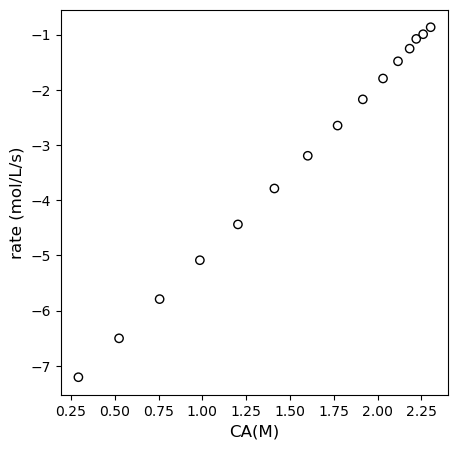

In [6]:
plt.figure(figsize = (5, 5))
plt.scatter(np.log(Cmod), np.log(r), edgecolor = 'black', color = 'none')
plt.xlabel('CA(M)', fontsize = 12)
plt.ylabel('rate (mol/L/s)', fontsize = 12)
plt.show()

#### Assessing linearity; linear regression

Is that linear? I really can't tell. It looks like parts of it are. The best way to tell is for me to fit a line to the data.  Clearly, there are 19 rate vs. CA pairs, so I can't find a single line that goes through all of them.  I can, however, regress the best fit line using any number of methods we discussed during recitation.  I can create a Vandermonde matrix and use linear algebra.  I can use `np.polyfit()`.  Or I can use the least squares version of `np.linalg.solve()`, which is called `np.linalg.lstsq()`.  All give the exact same slope and intercept values.  We'll discuss more what these various tools are doing during recitation this week.  For now, consider them similar to Excel's trendline.

[ 3.16737545 -8.19800598] 

m    = 3.1674 +/- 0.0446
b    = -8.1980 +/- 0.0758
SSE  = 0.0352
SST  = 63.9411
MSE  = 0.0023
RMSE = 0.0485
R2   = 0.9994
α    = 3.1674
k    = 2.7520E-04


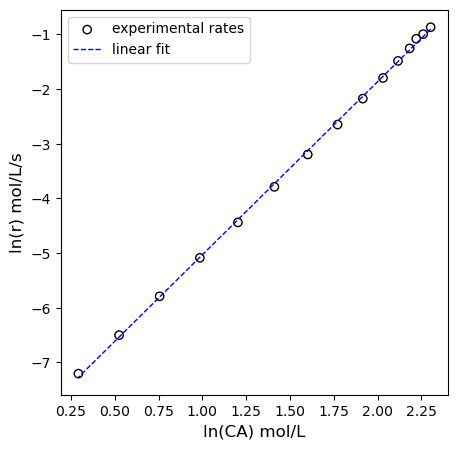

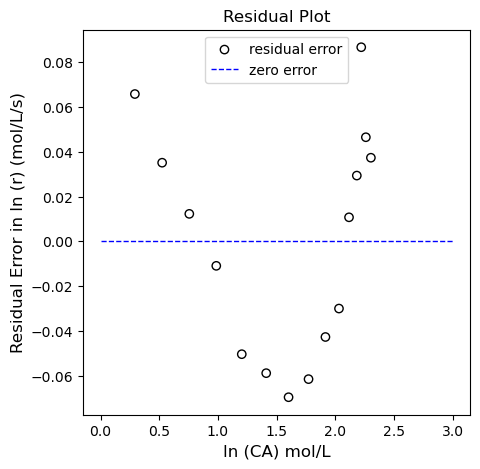

In [7]:
ydata = np.log(r)
xdata = np.log(Cmod)

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
α     = m
k     = np.exp(b)
labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2, α, k]

print(A, '\n')

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.4f} +/- {CIm:0.4f}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.4f} +/- {CIb:0.4f}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.4E}')
    else:
        print(f'{label:4s} = {value:0.4f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
# plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
# plt.ylim(floor(min(Y)), ceil(max(Y)))
plt.legend()
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred), marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('ln (CA) mol/L', fontsize = 12)
plt.ylabel('Residual Error in ln (r) (mol/L/s)', fontsize = 12)
plt.title('Residual Plot')
# plt.xlim(floor(min(X[:, 0])), ceil(max(X[:,0])))
plt.legend(loc = 'upper center')
plt.show()

OK, so it looks *sort of* linear...let's see what the slope and intercept are...this should tell us the reaction order and rate constant, respectively.

In [8]:
α     = m
k     = np.exp(b)
print(f'α = {α:3.2f}') 
print(f'k = {k:3.2E}') 

α = 3.17
k = 2.75E-04


Alright, so according to that analysis, this is a 3.17 order reaction and the rate constant is $2.75 \times 10^{-4}$...in whatever units correspond to a 3.16 order reaction.

The problem is: I don't buy it.  Now is the time to tell you that I generated this data by simulating a batch reactor with the following information:

\begin{align}
    r & = k{C_A}^3 \\
    k &= 4.5 \times 10^{-4} \ \mathrm{L^{2} \ mol^{-2} \ s^{-1}} \\
    C_{A0} &= 10 \ \mathrm{mol \ L^{-1}} \\
\end{align}

In other words, I generated this by simulating a 100% third order reaction, and I don't like that I'm getting 3.12 order from my differential analysis.  This is actually a common problem when using differential analysis, which is why I chose to highlight it.  The fundamental problem is that we are treating our rates as if we actually measured them, but remember: we estimated them using a finite difference method (similar to an Euler step...):

$$r|_{C_{A_n}} = \frac{dC_A}{dt}\bigg|_{C_{A_n}} \approx \frac{C_{A_{n+1}} - C_{A_{n}}}{t_{n+1} - t_n}$$

That approximation basically assumes that the derivative of concentration with respect to time is constant between $t_n$ and $t_{n+1}$. That can be a pretty good approximation if we consider small changes in time and concentration. That approximation can actually be pretty bad if we assume it is true over large changes in time and/or concentration.  

It is worth knowing that much of the above linear/polynomial regression and prediction is automated in `numpy` through `polyfit()`

In [9]:
xdata2 = np.log(Cmod)
ydata2 = np.log(r)
A4     = np.polyfit(xdata2, ydata2, 1)
print(A4)
order = A4[0]
k     = np.exp(A4[1])
print(order, k)

[ 3.16737545 -8.19800598]
3.1673754512884043 0.000275201781606887


In [64]:
# np.polyval(A4, 0)

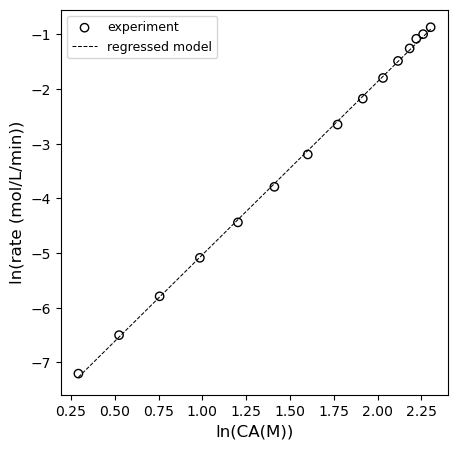

In [10]:
plt.figure(1, figsize = (5, 5))
plt.scatter(xdata2, ydata2, edgecolor = 'black', color = 'none', label = 'experiment')
plt.plot(xdata2, np.polyval(A4, xdata2), color = 'black', linestyle = 'dashed', linewidth = 0.75, label = 'regressed model')
plt.xlabel('ln(CA(M))', fontsize = 12)
plt.ylabel('ln(rate (mol/L/min))', fontsize = 12)
plt.legend(fontsize = 9)
plt.show()